# Chapter 6 - Financial Time Series and Related Models

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from PythonTsa.datadir import getdtapath
from PythonTsa.plot_acf_pacf import acf_pacf_fig
import statsmodels.api as sm
from PythonTsa.LjungBoxtest import plot_LB_pvalue
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from arch import arch_model
from statsmodels.graphics.api import qqplot
from scipy import stats
from statsmodels.tsa.stattools import kpss
from PythonTsa.Selecting_arma import choose_arma
from pmdarima.arima import ARIMA
from pmdarima import auto_arima

In [4]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Monthly Returns of Procter and Gamble Stock from 1961 to 2016

In [6]:
url1 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_ReturnsPG2/monthly%20returns%20of%20Procter%20n%20Gamble%20stock%20n%203%20market%20indexes%201961%20to%202016.csv')

pgret = pd.read_csv(url1, header = 0)

pgret.head()

,RET,vwretd,ewretd,sprtrn
0,0.042987,0.063952,0.082048,0.063156
1,0.054386,0.037005,0.060130,0.026870
2,0.054908,0.030610,0.049888,0.025536
3,0.034385,0.005645,0.009487,0.003843
4,-0.035222,0.025894,0.041572,0.019139


In [7]:
pgret = pgret['RET']
pgret

0      0.042987
1      0.054386
2      0.054908
3      0.034385
4     -0.035222
         ...   
667    0.020096
668    0.027946
669   -0.025409
670   -0.050000
671    0.019646
Name: RET, Length: 672, dtype: float64

In [8]:
dates = pd.date_range('1961-01', periods = len(pgret), freq = 'ME')
pgret.index = dates

pgret

1961-01-31    0.042987
1961-02-28    0.054386
1961-03-31    0.054908
1961-04-30    0.034385
1961-05-31   -0.035222
                ...   
2016-08-31    0.020096
2016-09-30    0.027946
2016-10-31   -0.025409
2016-11-30   -0.050000
2016-12-31    0.019646
Freq: ME, Name: RET, Length: 672, dtype: float64

Many `pgret` values are too small, which may affect convergence of the optimizer when estimating the parameters, so rescale it.

In [10]:
pgret = 100*pgret
pgret

1961-01-31    4.2987
1961-02-28    5.4386
1961-03-31    5.4908
1961-04-30    3.4385
1961-05-31   -3.5222
               ...  
2016-08-31    2.0096
2016-09-30    2.7946
2016-10-31   -2.5409
2016-11-30   -5.0000
2016-12-31    1.9646
Freq: ME, Name: RET, Length: 672, dtype: float64

In [11]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_stat, p_value, lags, critical_values = sm.tsa.kpss(pgret, regression='c', nlags='auto')

# Output the results
print(f"KPSS Test Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print(f"Lags used: {lags}")
print(f"Critical values: {critical_values}")
print()

# Interpretation
if p_value < 0.05:
    print("p-value < 0.05; Ha: series is Non-stationary")
else:
    print("p-value > 0.05; H0: series is Stationary")

KPSS Test Statistic: 0.11109642750067265
P-value: 0.1
Lags used: 4
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

p-value > 0.05; H0: series is Stationary


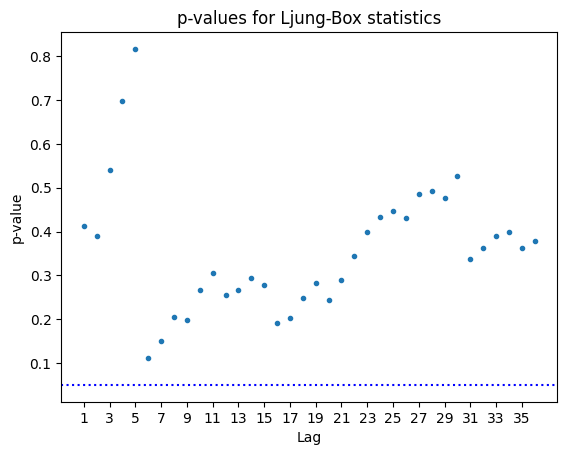

In [12]:
plot_LB_pvalue(pgret, noestimatedcoef = 0, nolags = 36)

It is the visual aspect of the dataframe below.

In [14]:
# Apply the Ljung-Box test on the 'pgret', on 10 lags.
df_ljungbox = acorr_ljungbox(pgret, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_ljungbox['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_ljungbox

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.671464,0.412542
2,1.888319,0.389006
3,2.157871,0.540294
4,2.210580,0.697093
5,2.228795,0.816666
6,10.339282,0.111072
7,10.747732,0.150008
8,10.943004,0.204950
9,12.286795,0.197620
10,12.290865,0.266062


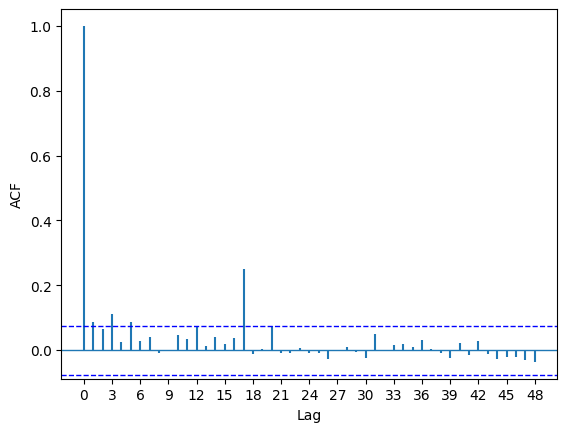

In [15]:
# Plot the Autocorrelation and Partial Autocorrelation functions for squared data
acf_pacf_fig(pgret**2, lag=48)    

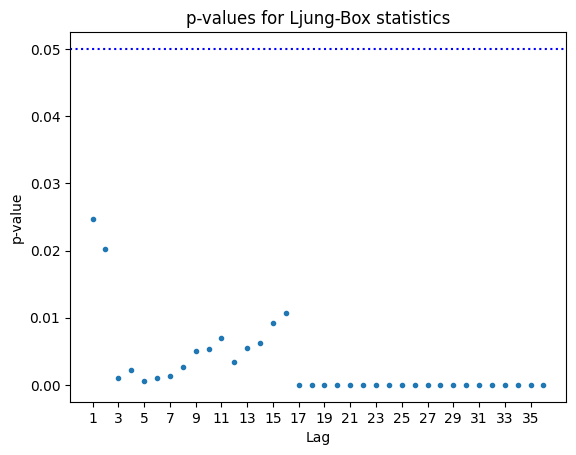

In [16]:
# Plot the Ljung-Box p-values for the squared time series data
plot_LB_pvalue(pgret**2,             # Input data (squared time series 'pgret**2') for autocorrelation testing
               noestimatedcoef=0,    # No estimated coefficients, this might refer to model fitting adjustments
               nolags=36)            # Number of lags

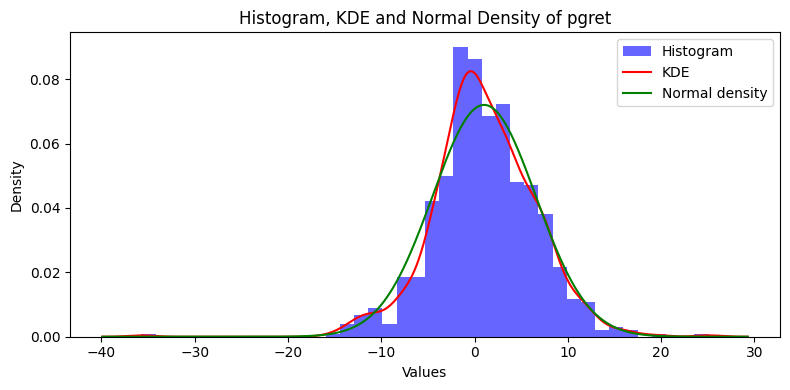

In [17]:
# Create a figure and axis for plotting
fig = plt.figure(figsize=(8, 4))                        # Set figure size for better visibility
ax = fig.add_subplot(111)                                  # Create a single subplot (111 means 1x1 grid, 1st subplot)

# Plot the histogram of the data
hfig = ax.hist(pgret,                                    # Input data (pgret) for histogram
               bins=40,                                   # Number of bins for the histogram
               density=True,                              # Normalize the histogram to form a probability density
               alpha=0.6,                                 # Set transparency of the histogram for better visibility
               color='blue',                              # Color of the histogram bars
               label='Histogram')                        # Label for the histogram (used in the legend)

# Kernel Density Estimation (KDE) for the distribution of the data
kde = sm.nonparametric.KDEUnivariate(pgret)                # Fit a non-parametric KDE model to the data
kde.fit()                                                 # Fit the KDE model

# Plot the KDE
ax.plot(kde.support, kde.density, color='red', label='KDE')  # Plot the KDE curve over the histogram

# Compute the mean and standard deviation of the data
smean = np.mean(pgret)                                    # Calculate the mean of the data
scal = np.std(pgret, ddof=1)                               # Calculate the sample standard deviation

# Calculate the normal density using the mean and standard deviation
normden = norm.pdf(kde.support, loc=smean, scale=scal)    # Generate the normal density function for the data

# Plot the normal density curve
ax.plot(kde.support, normden, label='Normal density', color='green')  # Plot the normal density curve

# Add labels and title to the plot
ax.set_xlabel('Values')                                  # Label for the x-axis
ax.set_ylabel('Density')                                 # Label for the y-axis
ax.set_title('Histogram, KDE and Normal Density of pgret') # Title for the plot

# Display legend to differentiate between the histogram, KDE, and normal density curve
ax.legend(loc='best')                                    # Place the legend at the best location

# Display the plot
plt.tight_layout()                                       # Adjust the layout to prevent overlap
plt.show()


The **ARCH (Autoregressive Conditional Heteroskedasticity)** model is a statistical model primarily used in time series analysis to model and forecast volatility or variance that changes over time. It is most commonly used in financial markets to model time-varying volatility, such as the volatility of stock returns or exchange rates.

In [19]:
# Fit the ARCH model to the 'pgret' time series data
archmod = arch_model(pgret)              # Initialize the ARCH model with the 'pgret' time series data
archmod = archmod.fit()                  # Fit the model to the data and estimate the parameters

# Print the summary of the fitted ARCH model
print(archmod.summary())                 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2739.382947188128
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2114.7081527736664
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2345.427788756573
Iteration:      4,   Func. Count:     28,   Neg. LLF: 2078.9687534584496
Iteration:      5,   Func. Count:     33,   Neg. LLF: 2078.967841623913
Iteration:      6,   Func. Count:     38,   Neg. LLF: 2078.967838978205
Iteration:      7,   Func. Count:     42,   Neg. LLF: 2078.9678389782484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2078.967838978205
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    RET   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likel

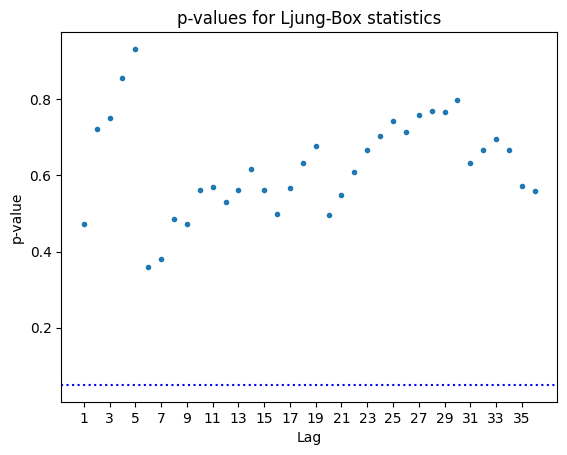

In [20]:
# Extract the standardized residuals from the fitted ARCH model
archresid = archmod.std_resid            # Get the standardized residuals from the ARCH model to check for autocorrelation

# Plot the Ljung-Box p-values for the standardized residuals to test for autocorrelation
plot_LB_pvalue(archresid,                # Pass the standardized residuals to the Ljung-Box test for autocorrelation detection
               noestimatedcoef=0,        # Number of estimated coefficients (set to 0 in this case, could be adjusted depending on model settings)
               nolags=36)                # Perform the Ljung-Box test for the first 36 lags to detect autocorrelation in residuals

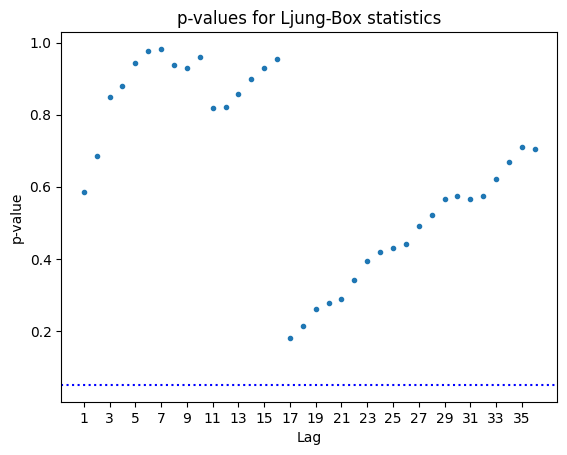

In [21]:
# Plot the Ljung-Box p-values for the squared standardized residuals to test for autocorrelation in variance
plot_LB_pvalue(archresid**2,         # Pass the squared standardized residuals
               noestimatedcoef=0,    # Number of estimated coefficients 
               nolags=36)            # Number of lags

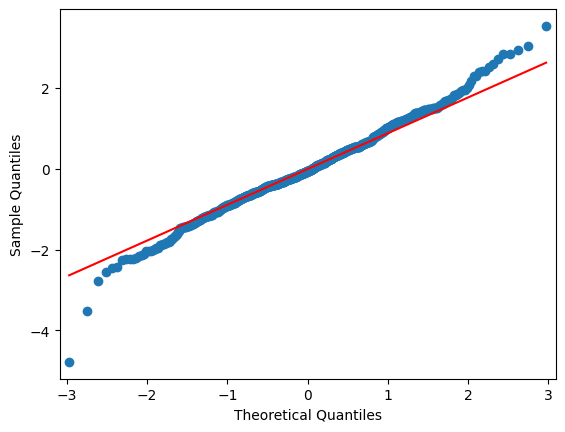

In [22]:
# Create a Q-Q plot to compare the distribution of the standardized residuals to a normal distribution
qqplot(archresid,    # Pass the standardized residuals for comparison
       line='q',     # Add a reference line to the plot for comparison with the quantiles of the normal distribution
       fit=True);    # Fit the distribution to the data and plot the fitted line

In [23]:
# Fit a GARCH(1,1) model with Student's t-distribution to model the conditional volatility of 'pgret'
garchT = arch_model(pgret,                 # Input time series data ('pgret') for volatility modeling
                    p=1,                   # The order of the autoregressive (AR) component (1 lag)
                    q=1,                   # The order of the moving average (MA) component (1 lag)
                    dist='StudentsT')      # Use Student's t-distribution for modeling the residuals (heavy tails)

# Fit the GARCH model to the data
res = garchT.fit()                         

# Print the summary of the fitted GARCH model
print(res.summary())                      

Iteration:      1,   Func. Count:      7,   Neg. LLF: 3121.5783259543086
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2091.0823011762477
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2168.142925570685
Iteration:      4,   Func. Count:     33,   Neg. LLF: 2072.21023019554
Iteration:      5,   Func. Count:     39,   Neg. LLF: 2072.2034430722
Iteration:      6,   Func. Count:     45,   Neg. LLF: 2072.2017351365184
Iteration:      7,   Func. Count:     51,   Neg. LLF: 2072.197119663295
Iteration:      8,   Func. Count:     57,   Neg. LLF: 2072.1968434439295
Iteration:      9,   Func. Count:     63,   Neg. LLF: 2072.196841697125
Iteration:     10,   Func. Count:     68,   Neg. LLF: 2072.196841697124
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2072.196841697125
            Iterations: 10
            Function evaluations: 68
            Gradient evaluations: 10
                        Constant Mean - GARCH Model Results           

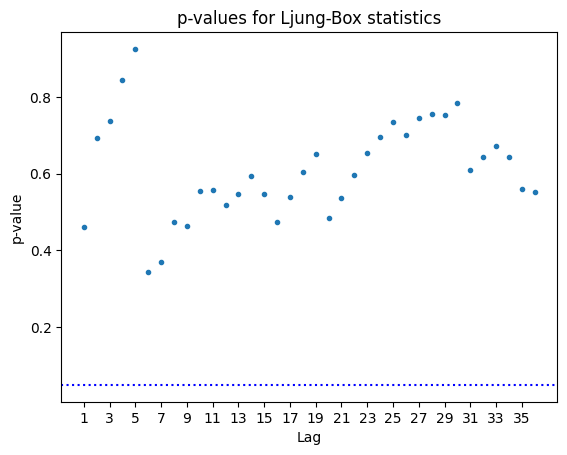

In [24]:
# Extract the standardized residuals from the fitted GARCH model with Student's t-distribution
archresidT = res.std_resid                  # Get the standardized residuals (errors) from the fitted GARCH model

# Plot the Ljung-Box p-values for the standardized residuals to test for autocorrelation
plot_LB_pvalue(archresidT,                  # Pass the standardized residuals to the Ljung-Box test for autocorrelation detection
               noestimatedcoef=0,           # Number of estimated coefficients (set to 0 here, could be adjusted based on model settings)
               nolags=36)                   # Perform the Ljung-Box test for the first 36 lags to check for autocorrelation in the residuals

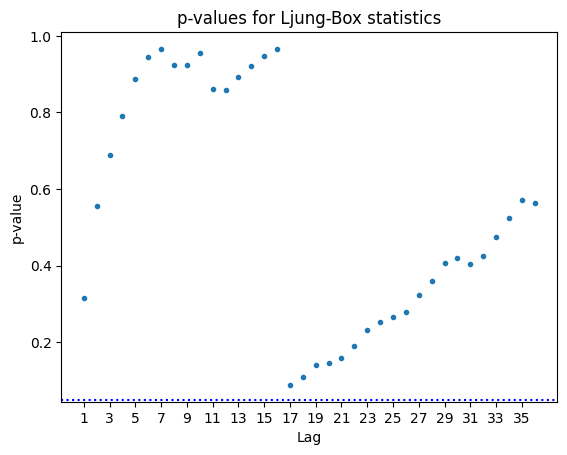

In [25]:
# Plot the Ljung-Box p-values for the squared standardized residuals to test for autocorrelation in variance
plot_LB_pvalue(archresidT**2,            # Pass the squared standardized residuals
               noestimatedcoef=0,        # Number of estimated coefficients
               nolags=36)                # First 36 lags

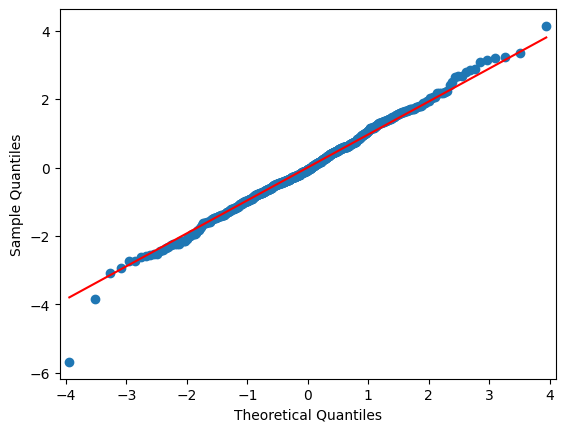

In [26]:
# Create a Q-Q plot to compare the distribution of the standardized residuals to a t-distribution
qqplot(archresidT,          # Pass the standardized residuals (archresidT) for comparison
       stats.t,             # Specify the t-distribution for comparison
       distargs=(9.62,),    # Set the degrees of freedom for the t-distribution (9.62 in this case)
       line='q',            # Add a reference line to the plot for comparison with the quantiles of the t-distribution
       fit=True);           # Fit the data to the t-distribution and plot the fitted line

## Germany DAX Daily Index from Oct 23, 2014 to July 7, 2019

In [28]:
url2 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_ReturnsDAX/DAX.csv')
dax = pd.read_csv(url2, header = 0)
dax.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-10-23,25.090000,25.270000,25.090000,25.250000,22.710241,7400
1,2014-10-24,25.139999,25.190001,25.139999,25.190001,22.656275,15200
2,2014-10-27,25.028000,25.028000,25.028000,25.028000,22.510571,300
3,2014-10-28,25.440001,25.510000,25.440001,25.510000,22.944088,3800
4,2014-10-29,25.660000,25.670000,25.660000,25.670000,23.087996,13600


In [29]:
dax.rename(columns = {'Adj Close' : 'index'}, inplace = True)

dax['logreturns'] = np.log(dax['index']/dax['index'].shift(1))

dax  =  dax.dropna()

dax['Date'] = pd.to_datetime(dax['Date'])
dax.set_index('Date', inplace=True)

dax.head()

,Open,High,Low,Close,index,Volume,logreturns
Date,,,,,,,
2014-10-24,25.139999,25.190001,25.139999,25.190001,22.656275,15200,-0.002379
2014-10-27,25.028000,25.028000,25.028000,25.028000,22.510571,300,-0.006452
2014-10-28,25.440001,25.510000,25.440001,25.510000,22.944088,3800,0.019075
2014-10-29,25.660000,25.670000,25.660000,25.670000,23.087996,13600,0.006253
2014-10-30,25.389999,25.389999,25.389999,25.389999,22.836159,100,-0.010968


In [30]:
logret  =  dax['logreturns']

logret.head()

Date
2014-10-24   -0.002379
2014-10-27   -0.006452
2014-10-28    0.019075
2014-10-29    0.006253
2014-10-30   -0.010968
Name: logreturns, dtype: float64

In [31]:
logret.tail()

Date
2019-07-15    0.008504
2019-07-16    0.000489
2019-07-17    0.000000
2019-07-18    0.000000
2019-07-19   -0.011844
Name: logreturns, dtype: float64

In [32]:
dax

,Open,High,Low,Close,index,Volume,logreturns
Date,,,,,,,
2014-10-24,25.139999,25.190001,25.139999,25.190001,22.656275,15200,-0.002379
2014-10-27,25.028000,25.028000,25.028000,25.028000,22.510571,300,-0.006452
2014-10-28,25.440001,25.510000,25.440001,25.510000,22.944088,3800,0.019075
2014-10-29,25.660000,25.670000,25.660000,25.670000,23.087996,13600,0.006253
2014-10-30,25.389999,25.389999,25.389999,25.389999,22.836159,100,-0.010968
...,...,...,...,...,...,...,...
2019-07-15,26.490000,26.601000,26.485001,26.570000,26.570000,3700,0.008504
2019-07-16,26.438999,26.583000,26.438999,26.583000,26.583000,900,0.000489
2019-07-17,26.583000,26.583000,26.583000,26.583000,26.583000,100,0.000000


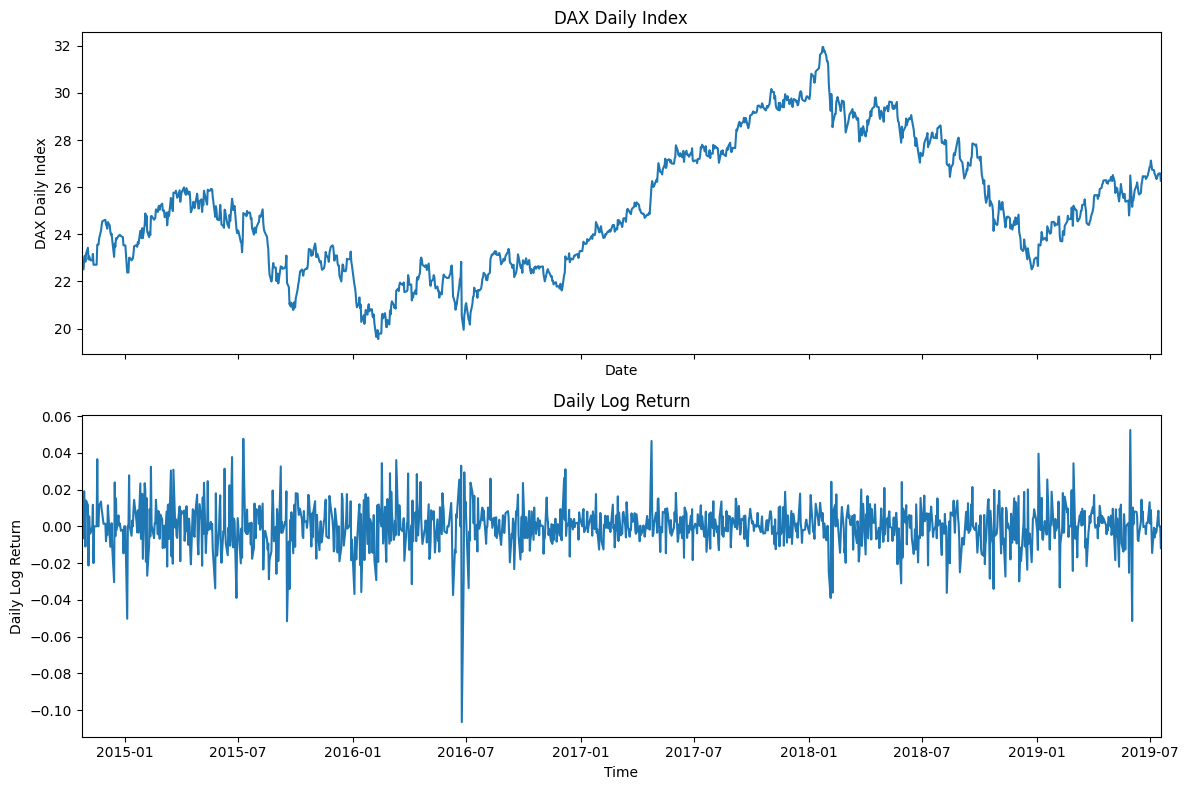

In [33]:
# Create a figure with 2 subplots, arranged vertically
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# Plot the DAX daily index in the first subplot (upper plot)
ax1.plot(dax['index'])         # Plot the DAX daily index
ax1.set_xlabel('Date')         # Set the x-axis label for the first plot
ax1.set_ylabel('DAX Daily Index')  # Set the y-axis label
ax1.set_title('DAX Daily Index')  # Title for the first plot

# Plot the daily log return in the second subplot (lower plot)
ax2.plot(dax['logreturns'])       # Plot the daily log return
ax2.set_xlabel('Time')         # Set the x-axis label for the second plot
ax2.set_ylabel('Daily Log Return') # Set the y-axis label
ax2.set_title('Daily Log Return')  # Title for the second plot

# Ensure that the x-axis is properly handled as datetime
ax1.set_xlim(pd.to_datetime('2014-10-24'), pd.to_datetime('2019-07-19'))
ax2.set_xlim(pd.to_datetime('2014-10-24'), pd.to_datetime('2019-07-19'))

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

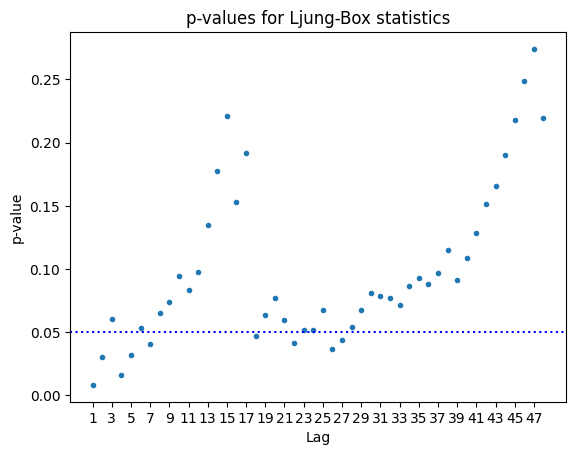

In [34]:
# Plot the Ljung-Box p-values for the logret time series 
plot_LB_pvalue(logret,               # The log return series (data to test autocorrelation)
               noestimatedcoef = 0,  # No estimated coefficients (for degrees of freedom adjustment)
               nolags = 48)          # Number of lags to test autocorrelation up to 48

## Simulating a GARCH(1,1) Process

Given a GARCH(1, 1) process as follows:

$$
X_t = \sigma_t \epsilon_t, \quad \epsilon_t \sim \text{iid} \, N(0, 1)
$$

Where:

$$
\sigma_t^2 = 0.1 + 0.2 X_{t-1}^2 + 0.6 \sigma_{t-1}^2
$$


In [36]:
sim_mod  =  arch_model(None, p = 1, q = 1)

params = [0, 0.1, 0.2, 0.6]    # in general, params = [r, omega, alpha, beta]

sim_data  =  sim_mod.simulate(params, nobs = 1000)

sim_data

,data,volatility,errors
0,-0.831862,0.779407,-0.831862
1,0.456151,0.776456,0.456151
2,0.041374,0.709468,0.041374
3,0.395038,0.634310,0.395038
4,-1.038590,0.610427,-1.038590
...,...,...,...
995,-0.002069,0.823313,-0.002069
996,-0.353345,0.711834,-0.353345
997,-0.805168,0.654977,-0.805168
998,-1.215749,0.697894,-1.215749


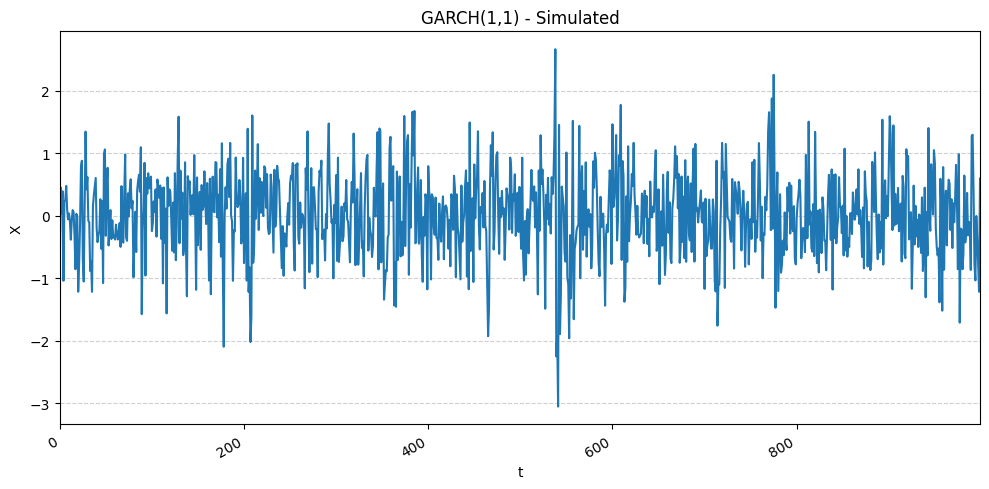

In [37]:
simdata = sim_data['data']


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(simdata)
ax.set_xlabel('t')
ax.set_ylabel('X')
ax.set_title('GARCH(1,1) - Simulated')
ax.set_xlim(0,999)
ax.grid(axis='y', linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()

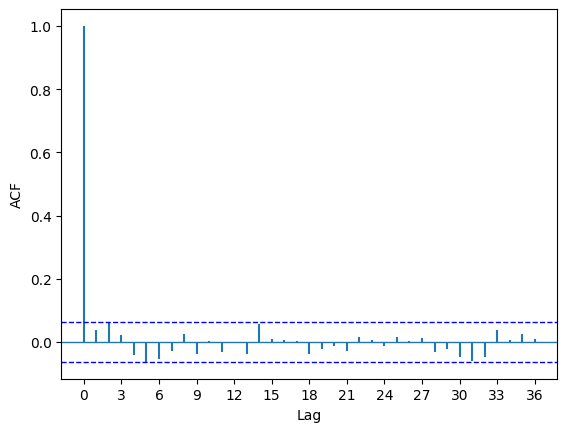

In [38]:
acf_pacf_fig(simdata, both = False, lag = 36)

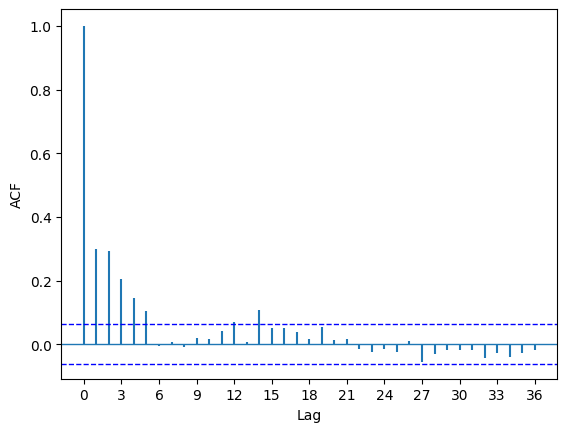

In [39]:
acf_pacf_fig(simdata**2, both = False, lag = 36)

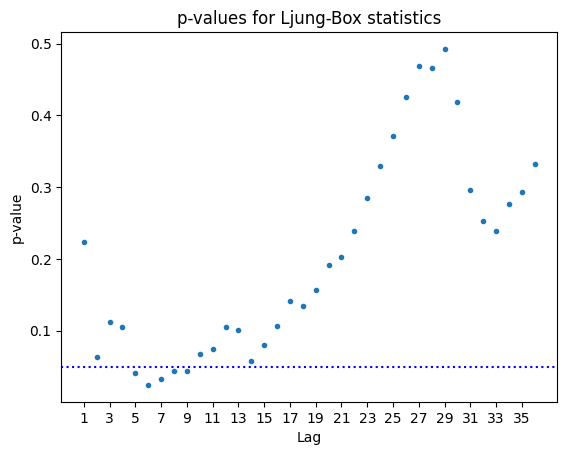

In [40]:
# Plot the Ljung-Box p-values for the simulated data series
plot_LB_pvalue(simdata,              # The simulated data series (data to test autocorrelation)
               noestimatedcoef = 0,  # No estimated coefficients (for degrees of freedom adjustment)
               nolags = 36)          # Number of lags to test autocorrelation up to 36

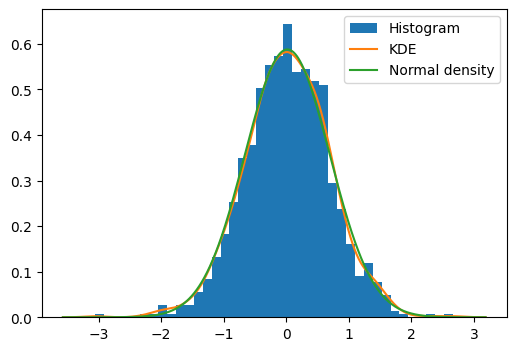

In [41]:
fig  =  plt.figure(figsize=(6, 4))
ax  =  fig.add_subplot(111)
hfig = ax.hist(simdata, bins = 40, density = True, label = 'Histogram')
kde  =  sm.nonparametric.KDEUnivariate(simdata)
kde.fit()
ax.plot(kde.support, kde.density, label = 'KDE')
smean = np.mean(simdata)
scal = np.std(simdata, ddof = 1)
normden = norm.pdf(kde.support, loc = smean, scale = scal)
ax.plot(kde.support, normden, label = 'Normal density')
ax.legend(loc = 'best');

## Standard & Poor’s 500 Index Daily Returns

In [43]:
url5 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_ReturnsSP500/SP500dailyreturns.csv')

ret = pd.read_csv(url5, header = None)

ret

,0
0,1.358200
1,2.214041
2,-0.205133
3,0.422136
4,-0.879151
...,...
5025,-2.711225
5026,4.959374
5027,0.856268
5028,-0.124158


In [44]:
ret.columns = ['returns']

ret = pd.Series(ret['returns'])

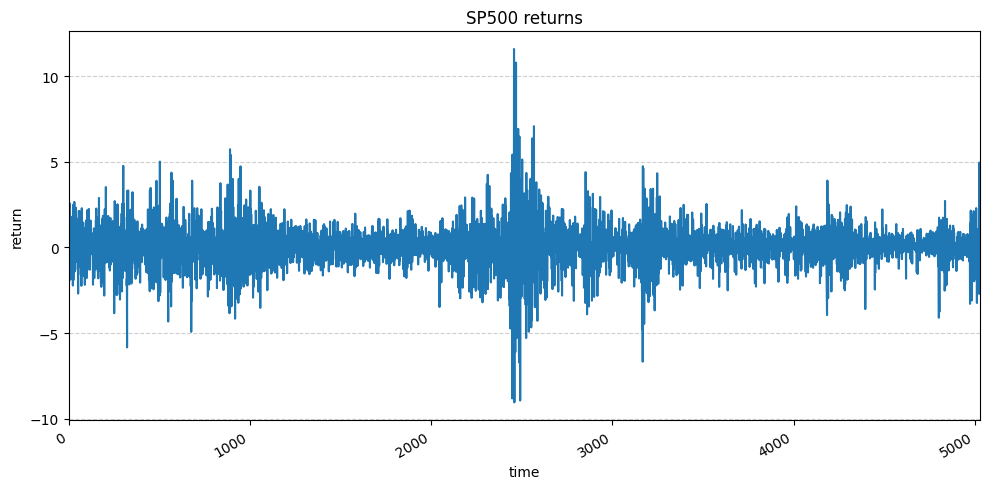

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ret)
ax.set_xlabel('time')
ax.set_ylabel('return')
ax.set_title('SP500 returns')
ax.set_xlim(0,5029)
ax.grid(axis='y', linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()

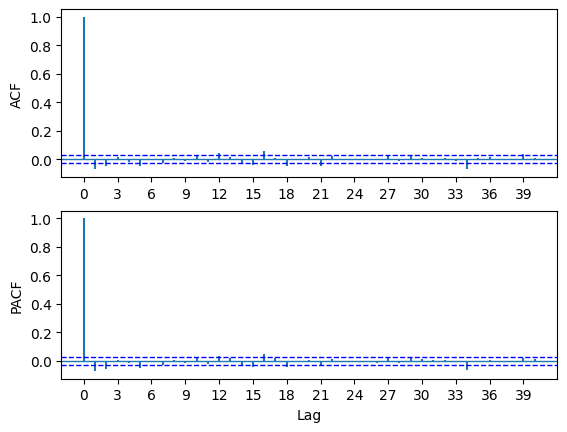

In [46]:
acf_pacf_fig(ret, both = True, lag = 40)

In [47]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_stat, p_value, lags, critical_values = kpss(ret, regression='c', nlags='auto')

# Output the results
print(f"KPSS Test Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print(f"Lags used: {lags}")
print(f"Critical values: {critical_values}")
print()

# Interpretation
if p_value < 0.05:
    print("p-value < 0.05; Ha: series is Non-stationary")
else:
    print("p-value > 0.05; H0: series is Stationary")

KPSS Test Statistic: 0.15015343399072809
P-value: 0.1
Lags used: 22
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

p-value > 0.05; H0: series is Stationary


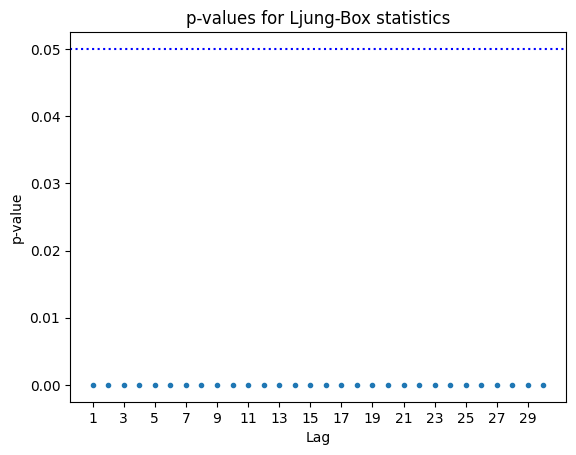

In [48]:
# Plot the Ljung-Box p-values for the return series
plot_LB_pvalue(ret,                  # The return series (data to test autocorrelation)
               noestimatedcoef = 0,  # No estimated coefficients (for degrees of freedom adjustment)
               nolags = 30)          # Number of lags to test autocorrelation up to 30

In [49]:
# Fit an ARMA(15, 0, 2) model with a constant trend to the return series 'ret'
arma152 = sm.tsa.SARIMAX(ret,                 # The time series data (returns) to fit the model
                        order = (15, 0, 2),   # ARMA(15, 0, 2) model (15 AR terms, 0 differencing, 2 MA terms)
                        trend = 'c').fit()    # Use a constant trend ('c' for constant mean)
# Display Summary
print(arma152.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5030
Model:              SARIMAX(15, 0, 2)   Log Likelihood               -8009.710
Date:                Mon, 10 Mar 2025   AIC                          16057.420
Time:                        10:21:03   BIC                          16181.360
Sample:                             0   HQIC                         16100.846
                               - 5030                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0575      0.041      1.414      0.157      -0.022       0.137
ar.L1         -0.5845      0.061     -9.594      0.000      -0.704      -0.465
ar.L2         -0.7568      0.059    -12.890      0.0

In [50]:
# Fit a SARIMAX model to the return series 'ret' with specified orders and no trend
arma122 = sm.tsa.SARIMAX(ret,                                                            # The time series data (returns) to fit the model
                         order = ([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1], 0, 2),  # Specify the ARMA order as a list of lags
                         trend = 'n').fit()                                              # No trend (set 'n' for no constant or trend)
# Display Summary
print(arma122.summary())

                                                  SARIMAX Results                                                  
Dep. Variable:                                                     returns   No. Observations:                 5030
Model:             SARIMAX([1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15], 0, 2)   Log Likelihood               -8011.944
Date:                                                     Mon, 10 Mar 2025   AIC                          16053.888
Time:                                                             10:21:15   BIC                          16151.736
Sample:                                                                  0   HQIC                         16088.172
                                                                    - 5030                                         
Covariance Type:                                                       opg                                         
                 coef    std err          z      P>|z|      [0.025      

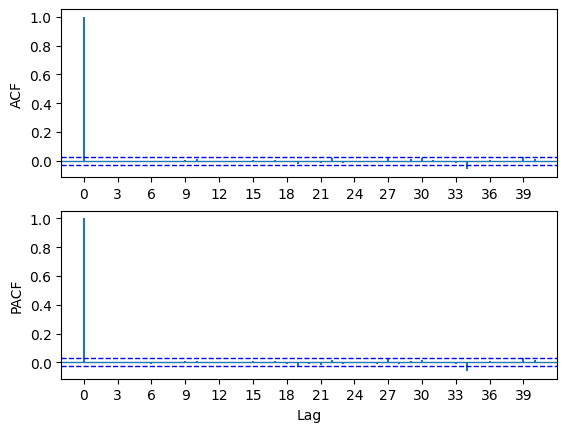

In [51]:
xresid = arma122.resid

acf_pacf_fig(xresid, both = True, lag = 40)

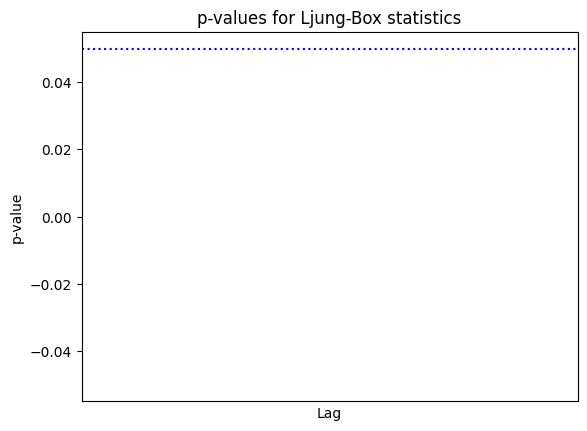

In [52]:
# Plot the Ljung-Box p-values for the residuals of the model
plot_LB_pvalue(xresid,                # The residuals from the model (data to test autocorrelation)
               noestimatedcoef = 14,  # The number of estimated coefficients (used to adjust degrees of freedom)
               nolags = 3)            # Number of lags to test autocorrelation up to 3

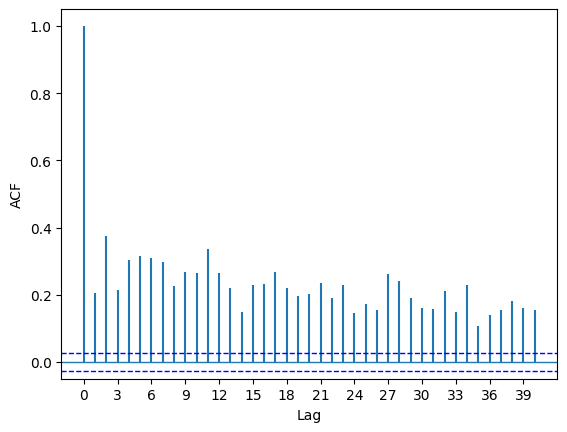

In [53]:
acf_pacf_fig(xresid**2, lag = 40)

In [54]:
# Fit a GARCH(2, 2) model to the residuals of the model (xresid) with a zero mean
garch = arch_model(xresid,                # The residuals from the model (used to fit the GARCH model)
                   p=2,                   # The order of the GARCH (autoregressive) term (2)
                   q=2,                   # The order of the ARCH (moving average) term (2)
                   mean='Zero')           # Specifies that the mean of the model is zero (no constant mean)

# Fit the GARCH model and suppress output display during fitting
garchmod = garch.fit(disp='off')  

# Display Summary
print(garchmod.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6941.21
Distribution:                  Normal   AIC:                           13892.4
Method:            Maximum Likelihood   BIC:                           13925.0
                                        No. Observations:                 5030
Date:                Mon, Mar 10 2025   Df Residuals:                     5030
Time:                        10:21:18   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0301  8.450e-03      3.558  3.738e-04 [1.

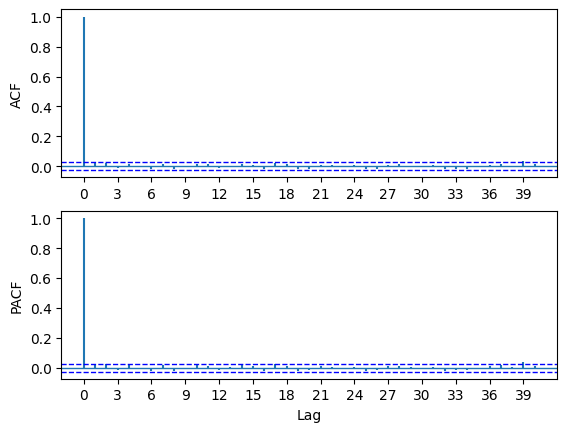

In [55]:
garchresid = garchmod.std_resid

acf_pacf_fig(garchresid, both = True, lag = 40)

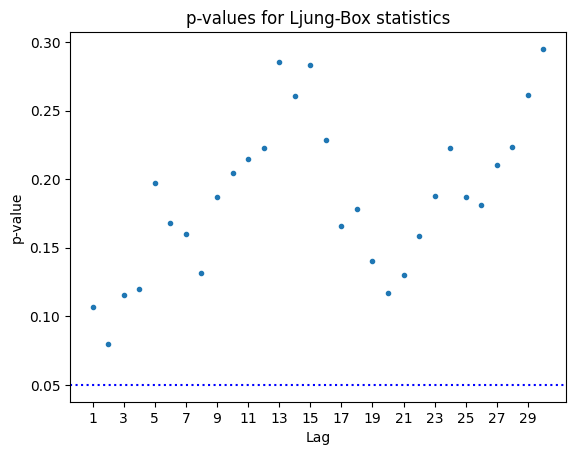

In [56]:
# Plot the Ljung-Box p-values for the residuals of the GARCH model
plot_LB_pvalue(garchresid,             # The residuals from the GARCH model (data to test autocorrelation)
               noestimatedcoef = 0,    # No estimated coefficients (for degrees of freedom adjustment)
               nolags = 30)            # Number of lags to test autocorrelation up to 30

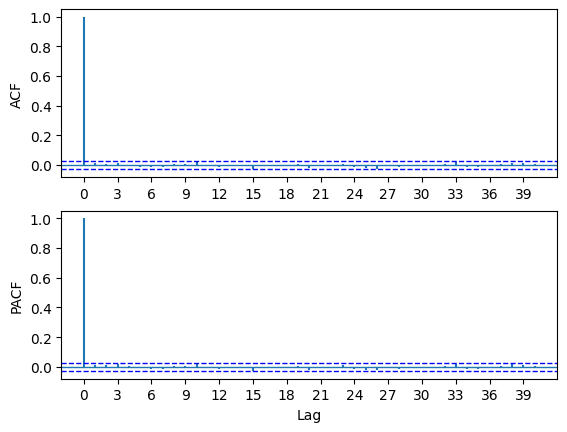

In [57]:
acf_pacf_fig(garchresid**2, both = True, lag = 40)

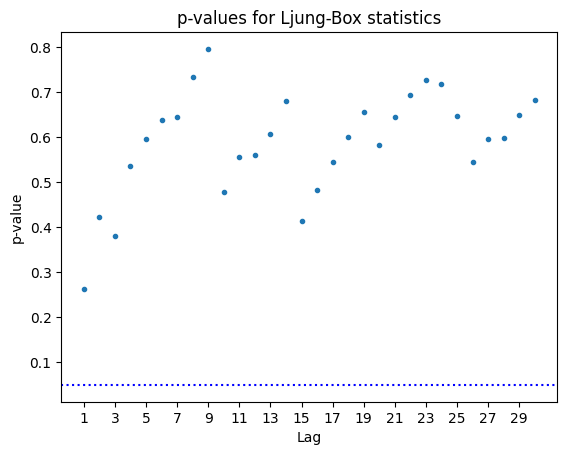

In [58]:
# Plot the Ljung-Box p-values for the squared residuals of the GARCH model
plot_LB_pvalue(garchresid**2,          # The squared residuals from the GARCH model (data to test autocorrelation in variance)
               noestimatedcoef = 0,    # No estimated coefficients (for degrees of freedom adjustment)
               nolags = 30)            # Number of lags to test autocorrelation up to 30

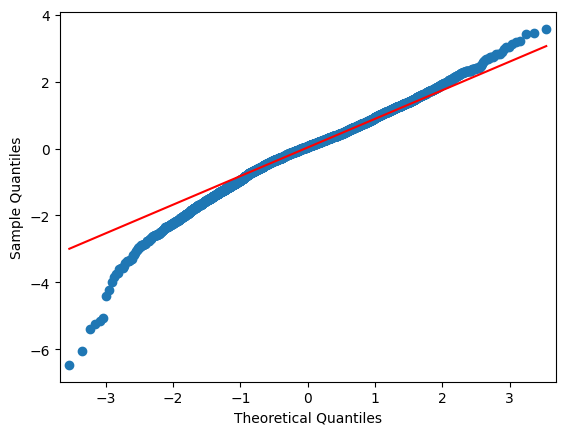

In [59]:
# Create a QQ plot to compare the distribution of GARCH residuals to a theoretical normal distribution
qqplot(garchresid,            # The residuals from the GARCH model to be compared to the normal distribution
       line='q',              # Add a line representing the quantiles of the normal distribution
       fit=True)              # Fit a normal distribution to the data and plot it for comparison
plt.show();                   # Display the QQ plot

## IBM Stock Log Returns

In [61]:
url6 = ('https://raw.githubusercontent.com/QuantLet/pyTSA/refs/heads/main/pyTSA_ReturnsIBM/ibmlogret.csv')

ibm = pd.read_csv(url6, header = 0)

ibm

,date,logreturn
0,2000/1/1,3.975555
1,2000/2/1,-8.842966
2,2000/3/1,14.261085
3,2000/4/1,-5.983268
4,2000/5/1,-3.827969
...,...,...
235,2019/8/1,-8.963958
236,2019/9/1,8.214685
237,2019/10/1,-8.380326
238,2019/11/1,0.536952


In [62]:
logret = ibm['logreturn']

logret.index = ibm['date']

logret.index = pd.to_datetime(logret.index, format='%Y/%m/%d')

logret

date
2000-01-01     3.975555
2000-02-01    -8.842966
2000-03-01    14.261085
2000-04-01    -5.983268
2000-05-01    -3.827969
                ...    
2019-08-01    -8.963958
2019-09-01     8.214685
2019-10-01    -8.380326
2019-11-01     0.536952
2019-12-01     0.868761
Name: logreturn, Length: 240, dtype: float64

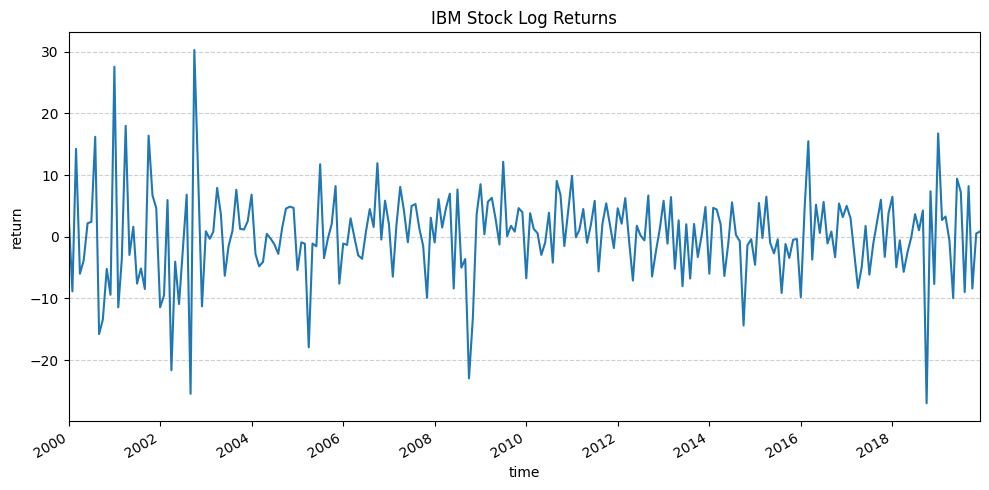

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(logret)
ax.set_xlabel('time')
ax.set_ylabel('return')
ax.set_title('IBM Stock Log Returns')
ax.grid(axis='y', linestyle='--', alpha=0.6)  
ax.set_xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2019-12-01'))


fig.autofmt_xdate()
plt.tight_layout()

In [64]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_stat, p_value, lags, critical_values = kpss(logret, regression='c', nlags='auto')

# Output the results
print(f"KPSS Test Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print(f"Lags used: {lags}")
print(f"Critical values: {critical_values}")
print()

# Interpretation
if p_value < 0.05:
    print("p-value < 0.05; Ha: series is Non-stationary")
else:
    print("p-value > 0.05; H0: series is Stationary")

KPSS Test Statistic: 0.07583649910331416
P-value: 0.1
Lags used: 5
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

p-value > 0.05; H0: series is Stationary


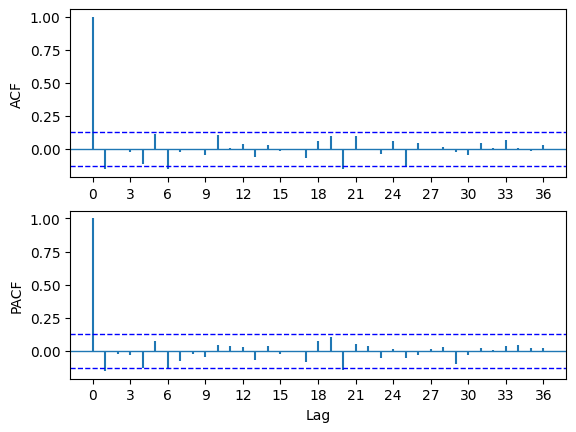

In [65]:
acf_pacf_fig(logret, both = True, lag = 36)

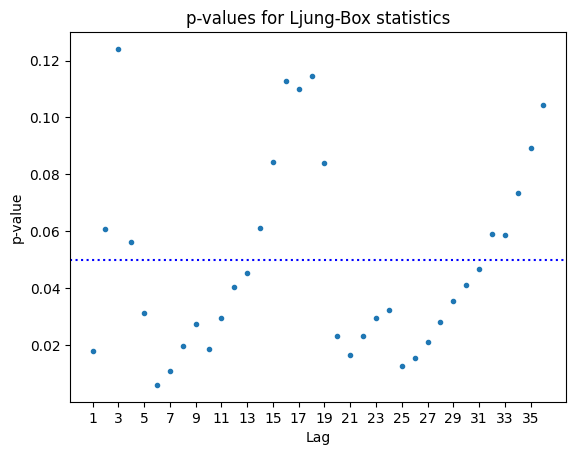

In [66]:
# Plot the Ljung-Box p-values for the log return series
plot_LB_pvalue(logret,               # The log return series (data to test autocorrelation)
               noestimatedcoef = 0,  # No estimated coefficients (for degrees of freedom adjustment)
               nolags = 36)          # Number of lags to test autocorrelation up to 36

In [67]:
from pmdarima import auto_arima

# Automatically select the best ARMA/ARIMA model
model = auto_arima(logret, 
                   start_p=0, max_p=2,   # Range for AR terms (p)
                   start_q=0, max_q=2,   # Range for MA terms (q)
                   seasonal=False,       # No seasonality for ARMA models
                   stepwise=True,        # Stepwise model selection
                   trace=True)           # Show model selection process

print(model.summary())  # Print the best model's summary

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1630.676, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1627.204, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1627.047, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1627.849, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1629.012, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1630.156, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1628.589, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.579 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -811.524
Date:                Mon, 10 Mar 2025   AIC                           1627.047
Time:                        10:21:28   BIC                           1634.009
Sample:                

In [68]:
# Fit an ARMA(0, 0, 1) model with a constant trend to the return series 'ret'
arma001 = sm.tsa.SARIMAX(logret,              # The time series data (returns) to fit the model
                        order = (0, 0, 1),    # ARMA(15, 0, 2) model (15 AR terms, 0 differencing, 2 MA terms)
                        trend = 'c').fit()    # Use a constant trend ('c' for constant mean)
# Display Summary
print(arma001.summary())

                               SARIMAX Results                                
Dep. Variable:              logreturn   No. Observations:                  240
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -811.294
Date:                Mon, 10 Mar 2025   AIC                           1628.589
Time:                        10:21:28   BIC                           1639.031
Sample:                    01-01-2000   HQIC                          1632.796
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2634      0.408      0.645      0.519      -0.537       1.064
ma.L1         -0.1578      0.050     -3.152      0.002      -0.256      -0.060
sigma2        50.5485      3.320     15.223      0.0

In [69]:
from pmdarima.arima import ARIMA

# Fit an ARMA(0,1) model (equivalent to ARIMA(0,0,1))
arma_pmd = ARIMA(order=(0, 0, 1), trend='n')  # 'n' removes the constant term

# Fit the model to the log returns
arma_pmd = arma_pmd.fit(logret)

# Print model summary
print(arma_pmd.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -811.524
Date:                Mon, 10 Mar 2025   AIC                           1627.047
Time:                        10:21:28   BIC                           1634.009
Sample:                    01-01-2000   HQIC                          1629.852
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1555      0.049     -3.190      0.001      -0.251      -0.060
sigma2        50.6396      3.292     15.383      0.000      44.187      57.092
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [70]:
armaresid = arma001.resid
armaresid

date
2000-01-01     3.712142
2000-02-01    -8.534780
2000-03-01    12.651565
2000-04-01    -4.250095
2000-05-01    -4.762113
                ...    
2019-08-01    -7.940035
2019-09-01     6.698211
2019-10-01    -7.586656
2019-11-01    -0.923753
2019-12-01     0.459566
Length: 240, dtype: float64

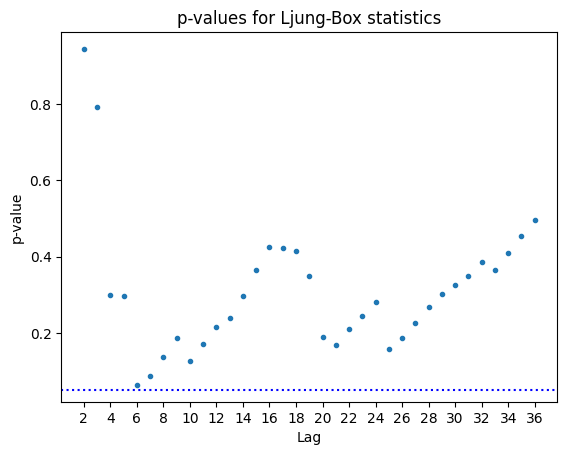

In [71]:
plot_LB_pvalue(armaresid, noestimatedcoef = 1, nolags = 36)

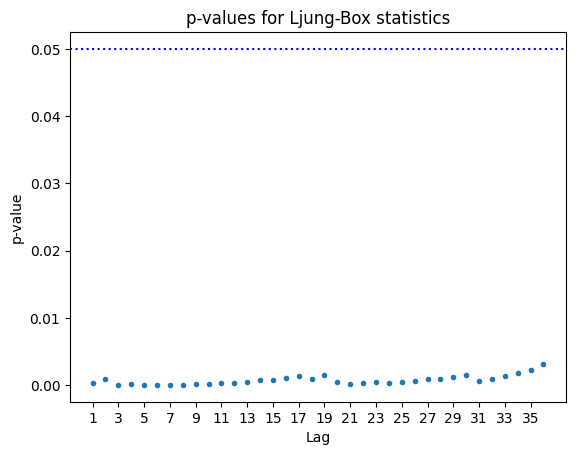

In [72]:
plot_LB_pvalue(armaresid**2, noestimatedcoef = 0, nolags = 36)

In [73]:
# Fit a GARCH(1,1) model to the residuals of the ARMA model
garch = arch_model(armaresid,         # Residuals from the ARMA model (input data for volatility modeling)
                   p=1,               # Number of lagged squared residual terms (GARCH component)
                   q=1,               # Number of lagged volatility terms (ARCH component)
                   mean='Zero'        # No mean model (assumes residuals have zero mean)
                   ).fit(disp='off')  # Fit the model and suppress output display

# Print the summary of the fitted GARCH(1,1) model
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -798.901
Distribution:                  Normal   AIC:                           1603.80
Method:            Maximum Likelihood   BIC:                           1614.24
                                        No. Observations:                  240
Date:                Mon, Mar 10 2025   Df Residuals:                      240
Time:                        10:21:29   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          4.4580     14.356      0.311      0.756 [-23.680, 32.59

In [74]:
# Fit an EGARCH(1,1) model to the residuals of the ARMA model
egarch = arch_model(armaresid,         # Residuals from the ARMA model (input for volatility modeling)
                    p=0,               # Number of lagged squared residual terms (GARCH component is zero)
                    o=1,               # Number of asymmetric (leverage effect) terms
                    q=1,               # Number of lagged volatility terms (ARCH component)
                    mean='Zero',       # No mean model (assumes residuals have zero mean)
                    vol='EGARCH'       # Specifies the Exponential GARCH model
                    ).fit(disp='off')  # Fit the model and suppress output display

# Print the summary of the fitted EGARCH(1,1) model
print(egarch.summary())

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                     EGARCH   Log-Likelihood:               -792.420
Distribution:                  Normal   AIC:                           1590.84
Method:            Maximum Likelihood   BIC:                           1601.28
                                        No. Observations:                  240
Date:                Mon, Mar 10 2025   Df Residuals:                      240
Time:                        10:21:29   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0961  5.795e-02      1.658  9.732e-02 [-1.75

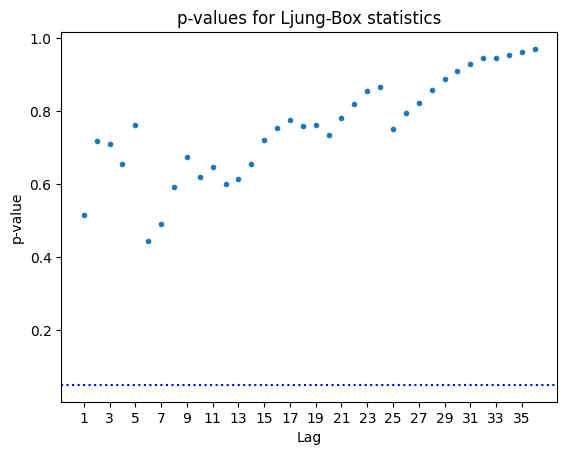

In [75]:
egarchresid = egarch.std_resid

plot_LB_pvalue(egarchresid, noestimatedcoef = 0, nolags = 36)

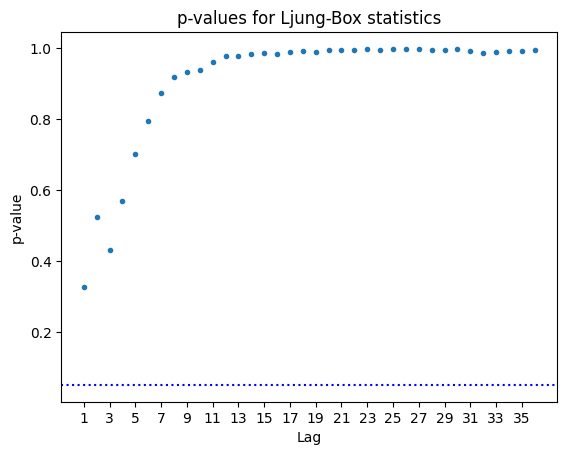

In [76]:
plot_LB_pvalue(egarchresid**2, noestimatedcoef = 0, nolags = 36)

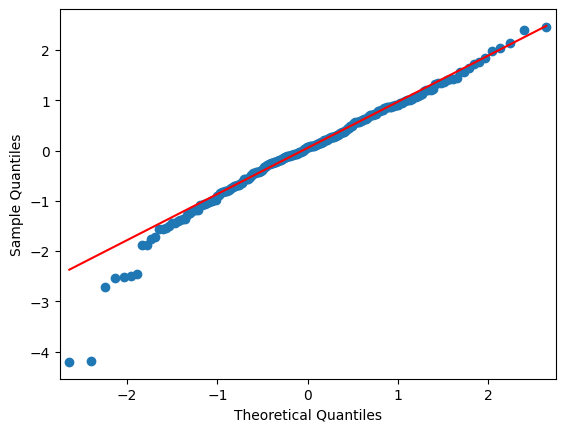

In [77]:
qqplot(egarchresid, line = 'q', fit = True);